<font font color='red' size="8"> **Facial Expression Recognition** </font>

# Abstract

After we finished Andrew Ng's Deep Learning course, We decided to work on a project in order to pratice what we have learn. We selected the Facial Expression Recognition dataset from [Kaggle](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) to see how good our model predict the expressons on human faces and categorize them in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral) and apply the results into solving business questions. We split the project into three phases: 
1. Replicating the [work](https://github.com/acharyarupesh/Facial-Emotion-Recognition-in-Live-Camera) from previous students to use CNN Sequencial model, VGG19 ConColutional Neural Network and Residual Networks 
2. Expanding the results to answer different business questions 
3. Representing our results to the public

# The Dataset

The dataset, named fer2013, consists of 48 * 48 pixel grayscale images of faces. The faces are more or less centered so that it occupises about the same amount of space in each image. We will categorize the facial expression in to one of the seven categories. The "emotion" column contains numeric code from 0-6, inclusive, for the emoton that is present in the images. The "pixels" column has a string, which is space_related pixel values in row major order, surrounded in quotes for each images. From a respective point of view, we will be predicting the "emotion" column .

The training set has 28,709 inputs while the pulic test set has 3,589. The final test set also consists of 3,859 exmaples

Pierre-Luc Carrier and Aaron Courville prepared this dataset as a part of the ongoing project and they allowed access to the Kaggle competition

### ResNet
The core idea of ResNet is introducing a so-called “identity shortcut connection” that skips one or more layers. The authors argue that stacking layers shouldn’t degrade the network performance, because we could simply stack identity mappings (layer that doesn’t do anything) upon the current network, and the resulting architecture would perform the same. This indicates that the deeper model should not produce a training error higher than its shallower counterparts. They hypothesize that letting the stacked layers fit a residual mapping is easier than letting them directly fit the desired underlaying mapping. And the residual block above explicitly allows it to do precisely that.

As a matter of fact, ResNet was not the first to make use of shortcut connections, Highway Network introduced gated shortcut connections. These parameterized gates control how much information is allowed to flow across the shortcut. Similar idea can be found in the Long Term Short Memory (LSTM) cell, in which there is a parameterized forget gate that controls how much information will flow to the next time step. Therefore, ResNet can be thought of as a special case of Highway Network.

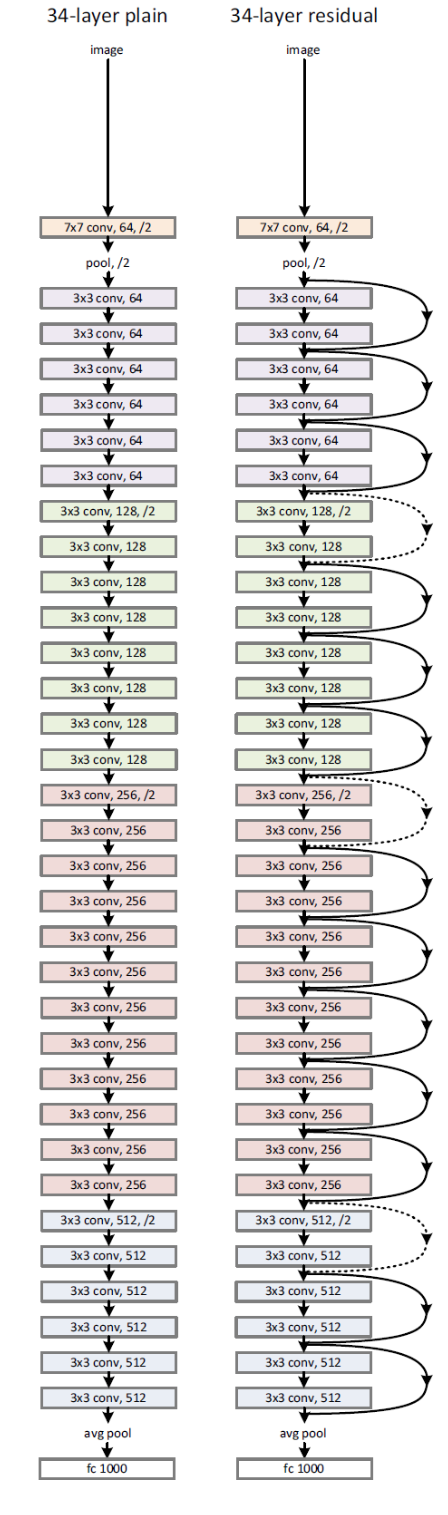

In [ ]:
#Grant access to your Google file first 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing required libraries

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
tf.compat.v1.reset_default_graph() #This will reset the current loaded graph to avoid issues
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) #Providing GPU
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.get_session(sess)

In [ ]:
#read the dataset
with open("/content/drive/MyDrive/fer2013.csv") as f:
    content = f.readlines()
#Converting lines to array as the lines represent the pixels
lines = np.array(content)

num_of_instances = lines.size

In [ ]:
x_train, y_train, x_test, y_test = [], [], [], []

#creating training and testing data [4]
for i in range(1,num_of_instances):
    emotion, img, usage = lines[i].split(",")
    val = img.split(" ")
            
    pixels = np.array(val, 'float32')
        
    emotion = keras.utils.to_categorical(emotion, 7)
    #Creating training and testing set
    if 'Training' in usage:
        y_train.append(emotion)
        x_train.append(pixels)
    elif 'PublicTest' in usage:
        y_test.append(emotion)
        x_test.append(pixels)

In [ ]:
#Converting our training variables to NP array
x_train = np.asarray(x_train, 'float32')
y_train = np.asarray(y_train, 'float32')
x_test = np.asarray(x_test, 'float32')
y_test = np.asarray(y_test, 'float32')

#Since the images are 48x48, reshaping the array to 48x48. And 1 is for grayscale and -1 will automatically detect the number of images.
x_train = x_train.reshape([-1, 48, 48, 1])
x_test = x_test.reshape([-1, 48, 48, 1])

In [ ]:
import tflearn
import numpy as np
from numpy import genfromtxt
from tflearn.data_preprocessing import ImagePreprocessing
import keras

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#RealTime image preprocessing
img_prep = ImagePreprocessing()

# Zero Center (With mean computed over the whole dataset)
img_prep.add_featurewise_zero_center()

# STD Normalization (With standard deviation computed over the whole dataset)
img_prep.add_featurewise_stdnorm()

In order to increase the number of images, we will conduct data augmentation.

Data Augmentation is the process of adding moderately modified copies of exiting data or newly synthezied data. It functions as a regularizer and aids in reducing overfitting when training a machne learning model. Similar to oversampling in data analysis .

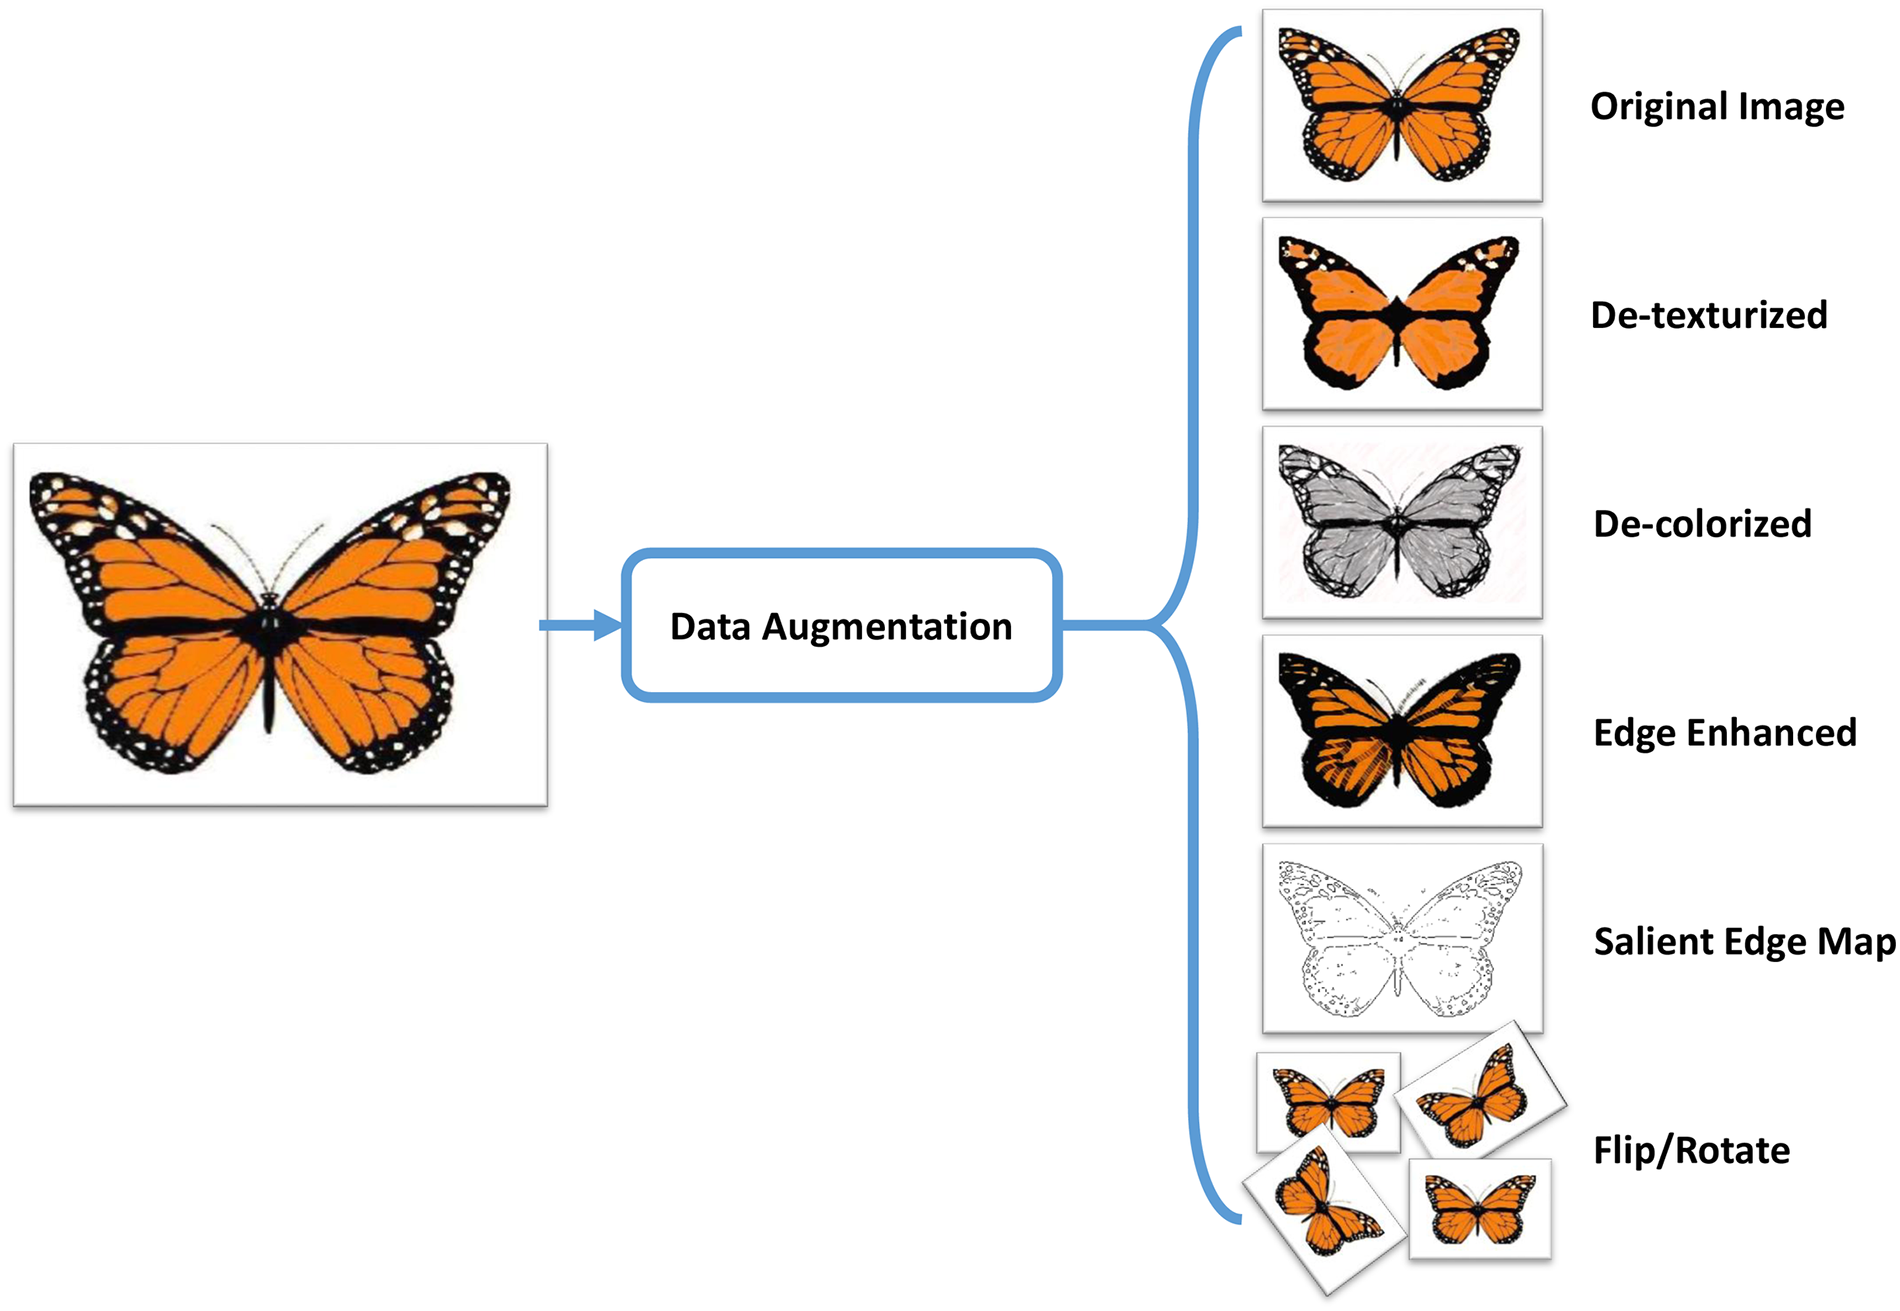

In [ ]:
#This will augment the given image
img_aug = tflearn.ImageAugmentation()
#This will randomly flip the image for better training
img_aug.add_random_flip_leftright()

In [ ]:
#Creating residual architecture
n = 5  #[3]
net = tflearn.input_data(shape=[None, 48, 48, 1], data_preprocessing=img_prep, data_augmentation=img_aug)
net = tflearn.conv_2d(net, nb_filter=16, filter_size=3, regularizer='L2', weight_decay=0.0001)
net = tflearn.residual_block(net, n, 16)
net = tflearn.residual_block(net, 1, 32, downsample=True)
net = tflearn.residual_block(net, n-1, 32)
net = tflearn.residual_block(net, 1, 64, downsample=True)
net = tflearn.residual_block(net, n-1, 64)
# Normalizing the previous batches by converting activation function close to 0 and loss function close to 1
net = tflearn.batch_normalization(net)
net = tflearn.activation(net, 'relu')
net = tflearn.global_avg_pool(net)
    
# Creating final layer
net = tflearn.fully_connected(net, 7, activation='softmax')
mom = tflearn.Momentum(learning_rate=0.1, lr_decay=0.0001, decay_step=32000, staircase=True, momentum=0.9)
net = tflearn.regression(net, optimizer=mom,
                         loss='categorical_crossentropy')

In [ ]:
model = tflearn.DNN(net, checkpoint_path='models/emotion_classification',
                    max_checkpoints=20, tensorboard_verbose=0,
                    clip_gradients=0.)

In [ ]:
#training the model
model.fit(x_train,y_train, n_epoch = 200, snapshot_epoch = True, snapshot_step = 500,
         show_metric=True, batch_size = 128, shuffle=True, run_id = "200_emotion")

Training Step: 103105  | total loss: 0.08884 | time: 760.723s
| Momentum | epoch: 001 | loss: 0.08884 - acc: 0.9713 -- iter: 18560/28709


In [ ]:
#saving trained model
model.save('resnet_emotion_1.tfl')

In [ ]:
#loading the previously trained model to retrain it
#model.load('/content/drive/MyDrive/resnet_emotion_1.tfl.data-00000-of-00001')

In [ ]:
#evaluating the test score
score = model.evaluate(x_test, y_test)
score

In [ ]:
def detect_emotion(emotions):
    """
    This function classifies the image by converting it NP into array and then predicting the results
    """
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [ ]:
img = image.load_img("/content/drive/MyDrive/sad face.jpg", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img) #Converting image to array
x = np.expand_dims(x, axis = 0) #This will expand the shape of an array as we already converted the input image to 48x48

emotion_prediction = model.predict(x)
detect_emotion(emotion_prediction[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()

### Camera Capture
Using a webcam to capture images for processing on the runtime.

In [ ]:
# I have no idea who is the author of the code in this cell that saves an image from a webcam  inside google colab.
# It comes from a notebook called "📸 Take a photo with your webcam"

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))
#   with open(filename, 'wb') as f:
#     f.write(binary)
#   return len(binary)

In [ ]:
Real_pic = take_photo() # click

**Citations**

For Camera capture- https://gist.github.com/ricardodeazambuja/b79724bd0d091fed4c0d44143e9c3127

For VGG19 and ResNet - https://github.com/tflearn/tflearn/tree/master/examples/images

For tflearn - http://tflearn.org/tutorials/

Article on Facial Emotion Recognition using CNN - http://sefiks.com/2018/01/01/facial-expression-recognition-with-keras/

VGG19 CNN - https://www.mathworks.com/help/deeplearning/ref/vgg19.html;jsessionid=ccf9599bd865b423281a56299a68
